In [40]:
import numpy as np
import cv2 as cv

import matplotlib.pyplot as plt

import os

# Data loading

In [41]:
# Set the data folder path and get the list of files
folder_path = 'data/raw_Tiff'
files = sorted(os.listdir(folder_path))

# Load all images and extract timestamps 
images = [cv.imread(os.path.join(folder_path, f), cv.IMREAD_GRAYSCALE) for f in files]
timestamps = [f.split('--T')[-1].replace('.tif', '') for f in files]

print(f"Loaded {len(images)} images")

Loaded 130 images


In [42]:
img_1 = images[0]

print(f'Height: {img_1.shape[0]}')
print(f'Width: {img_1.shape[1]}')

Height: 2048
Width: 2048


# Preprocessing  

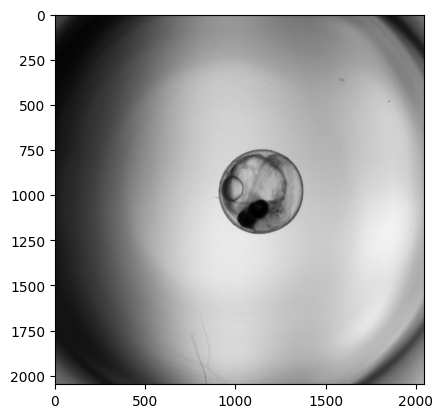

In [43]:
# Display the image
plt.imshow(img_1, cmap='gray')

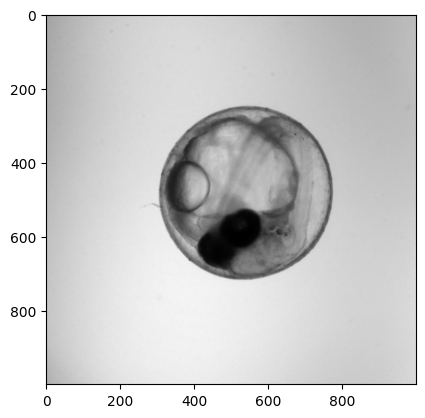

In [44]:
# Crop the image to focus on a smaller region
small_img = img_1[500:1500, 600:1600]
plt.imshow(small_img, cmap='gray')

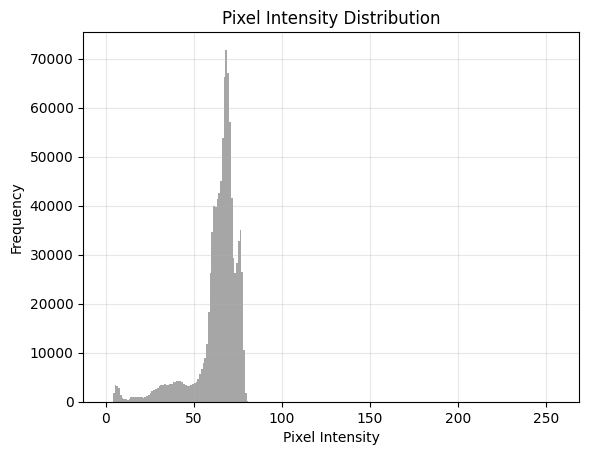

  Min: 4
  Max: 81


In [45]:
# Pixel intensity distribution 

# Histogram
plt.hist(small_img.ravel(), bins=256, range=(0, 256), color='gray', alpha=0.7)
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Pixel Intensity Distribution')
plt.grid(True, alpha=0.3)
plt.show()

# Display statistics
print(f"  Min: {np.min(small_img)}")
print(f"  Max: {np.max(small_img)}")

(np.float64(-0.5), np.float64(999.5), np.float64(999.5), np.float64(-0.5))

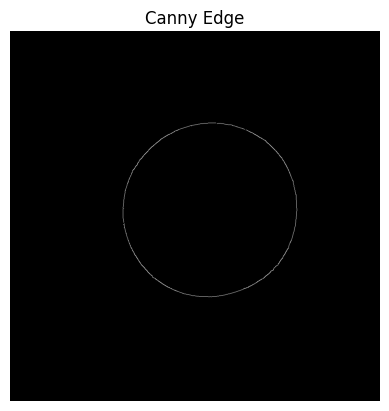

In [46]:
# Canny threshold values here
minThres = 52
maxThres = 118

# Apply Canny edge detection
edges = cv.Canny(small_img, minThres, maxThres)

plt.imshow(edges, cmap='gray')
plt.title('Canny Edge')
plt.axis('off')

In [47]:
# Convert edges to BGR for visualization
cimg = cv.cvtColor(edges,cv.COLOR_GRAY2BGR)

# detect circles using Hough Circles transform
circles = cv.HoughCircles(small_img,
                          method = cv.HOUGH_GRADIENT,
                          dp = 1,
                          minDist = 20,
                          param1 = 50,
                          param2 = 50,
                          minRadius = 200,
                          maxRadius=0) 

circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv.circle(cimg,(i[0],i[1]),2,(0,0,255),3)

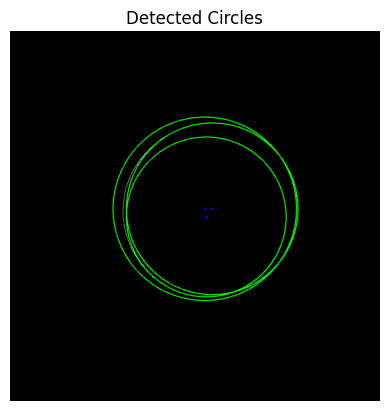

Number of circles detected: 3


In [48]:
plt.imshow(cimg, cmap='gray')
plt.title('Detected Circles')
plt.axis('off')
plt.show()

print(f"Number of circles detected: {len(circles[0])}")

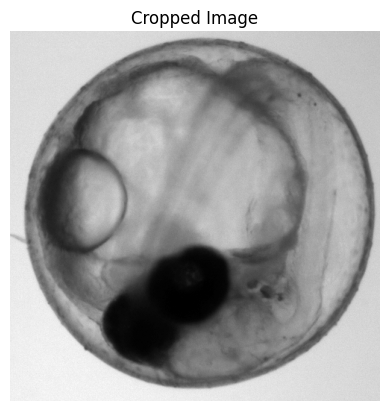

In [49]:
# Average the centers of all detected circles
avg_center_x = int(np.mean(circles[0, :, 0]))
avg_center_y = int(np.mean(circles[0, :, 1]))

# Find the largest radius among all detected circles
max_radius = int(np.max(circles[0, :, 2]))

# Crop the image based on the averaged center and largest radius
x_start = max(0, avg_center_x - max_radius)
x_end = min(small_img.shape[1], avg_center_x + max_radius)
y_start = max(0, avg_center_y - max_radius)
y_end = min(small_img.shape[0], avg_center_y + max_radius)

# Crop the original grayscale image (small_img)
cropped_img = small_img[y_start:y_end, x_start:x_end]

# Display the cropped image
plt.imshow(cropped_img, cmap='gray')
plt.title('Cropped Image')
plt.axis('off')
plt.show()

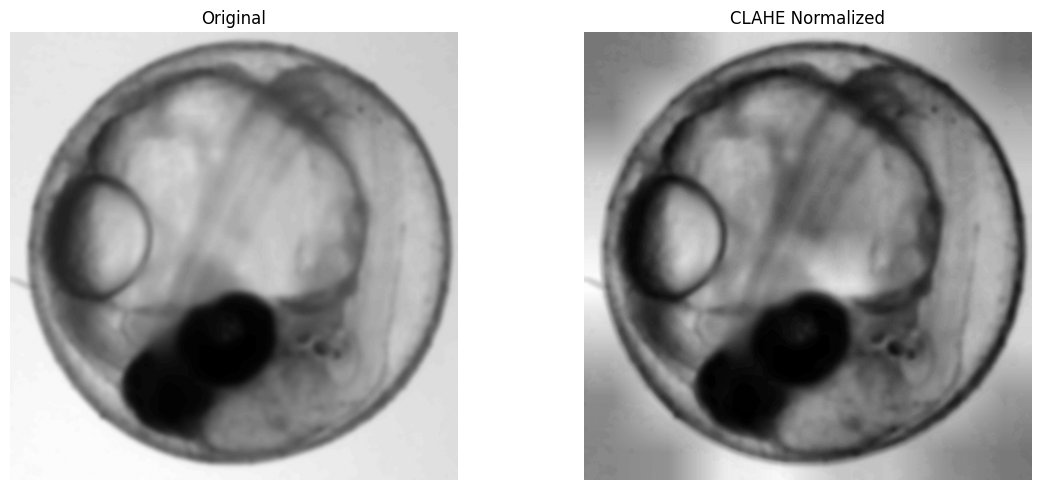

In [50]:
# Crop all images to embryo region
processed_images = []
for img in images:
    small_img = img[500:1500, 600:1600]
    embryo = small_img[y_start:y_end, x_start:x_end]
    processed_images.append(embryo)

processed_images = np.array(processed_images)

# Apply bilateral filter to reduce noise while preserving edges
processed_images = [cv.bilateralFilter(image, 9, 75, 75) for image in processed_images]

# Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) for normalization
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
normalized_images = np.array([clahe.apply(img) for img in processed_images])

# Visualize normalization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(processed_images[0], cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')
axes[1].imshow(normalized_images[0], cmap='gray')
axes[1].set_title('CLAHE Normalized')
axes[1].axis('off')
plt.tight_layout()
plt.show()

In [51]:
# Save processed images to output folder
output_folder = 'data/processed_Tiff'

# Save each processed image with its timestamp
for i, (img, timestamp) in enumerate(zip(processed_images, timestamps)):
    # Create filename with timestamp
    filename = f"{timestamp}.tif"
    output_path = os.path.join(output_folder, filename)
    
    # Save the image
    cv.imwrite(output_path, img)

print(f"Saved {len(processed_images)} processed images to {output_folder}/")

Saved 130 processed images to data/processed_Tiff/


# Heart Detection

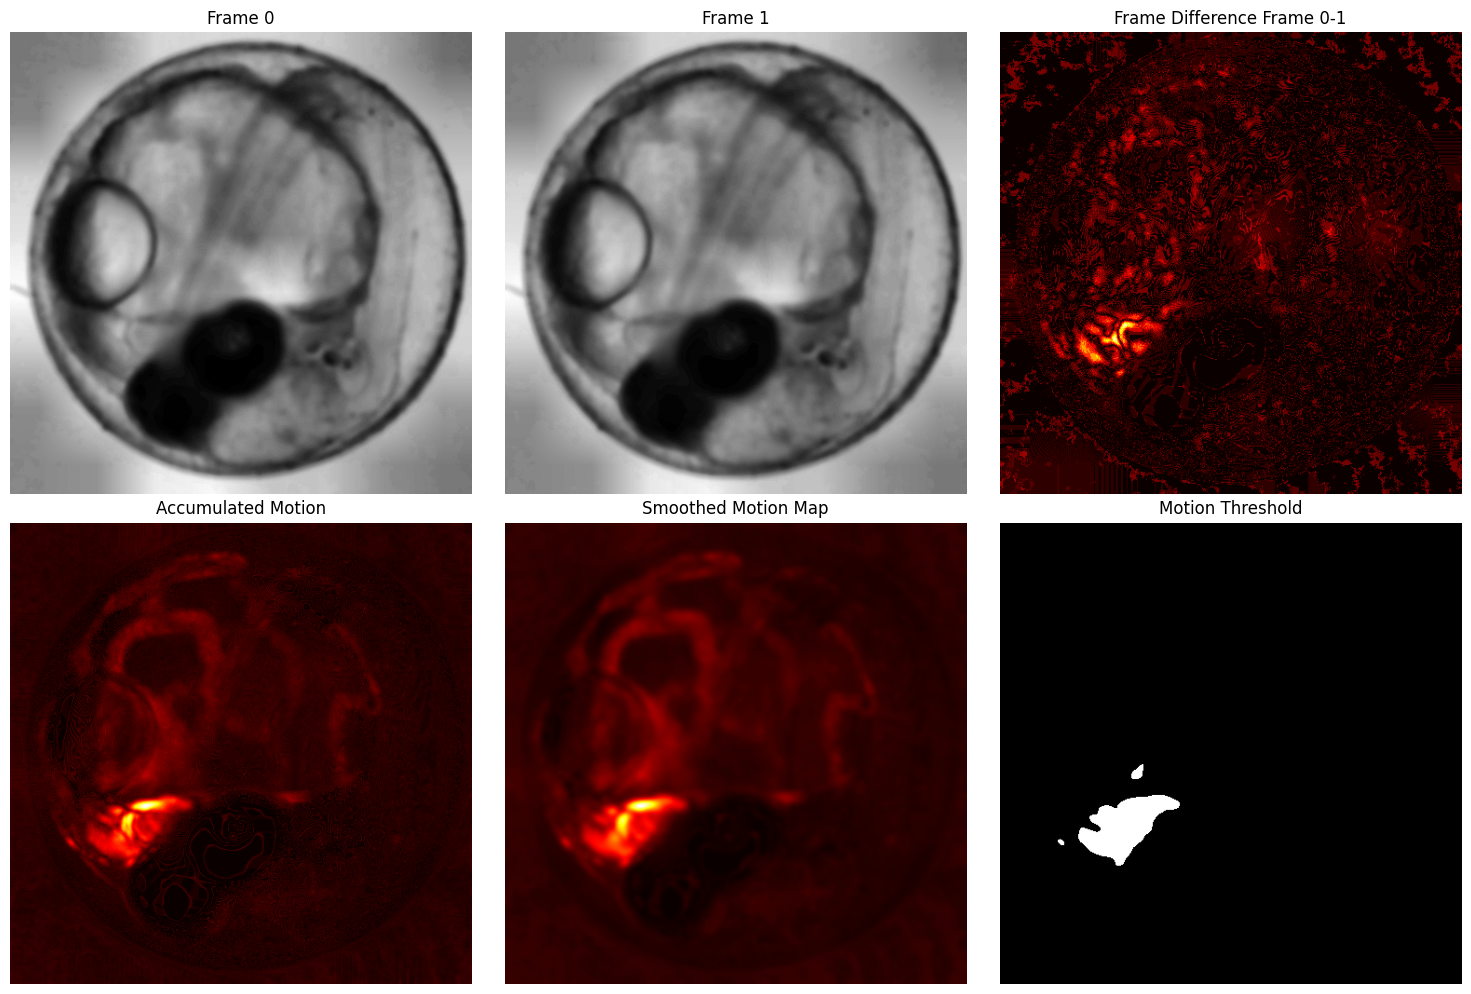

In [52]:
# Compute absolute differences between consecutive frames
frame_diffs = []
for i in range(len(normalized_images) - 1):
    diff = cv.absdiff(normalized_images[i], normalized_images[i+1])
    frame_diffs.append(diff)

frame_diffs = np.array(frame_diffs)

# Sum all differences to find regions with most motion
motion_accumulator = np.sum(frame_diffs, axis=0)

# Normalize for visualization
motion_map = (motion_accumulator / motion_accumulator.max() * 255).astype(np.uint8)

# Apply Gaussian blur to reduce noise
motion_map_smooth = cv.GaussianBlur(motion_map, (15, 15), 0)

# Threshold to find high-motion regions
_, motion_threshold = cv.threshold(motion_map_smooth, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

# Visualize
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(normalized_images[0], cmap='gray')
axes[0, 0].set_title('Frame 0')
axes[0, 0].axis('off')

axes[0, 1].imshow(normalized_images[1], cmap='gray')
axes[0, 1].set_title('Frame 1')
axes[0, 1].axis('off')

axes[0, 2].imshow(frame_diffs[0], cmap='hot')
axes[0, 2].set_title('Frame Difference Frame 0-1')
axes[0, 2].axis('off')

axes[1, 0].imshow(motion_accumulator, cmap='hot')
axes[1, 0].set_title('Accumulated Motion')
axes[1, 0].axis('off')

axes[1, 1].imshow(motion_map_smooth, cmap='hot')
axes[1, 1].set_title('Smoothed Motion Map')
axes[1, 1].axis('off')

axes[1, 2].imshow(motion_threshold, cmap='gray')
axes[1, 2].set_title('Motion Threshold')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

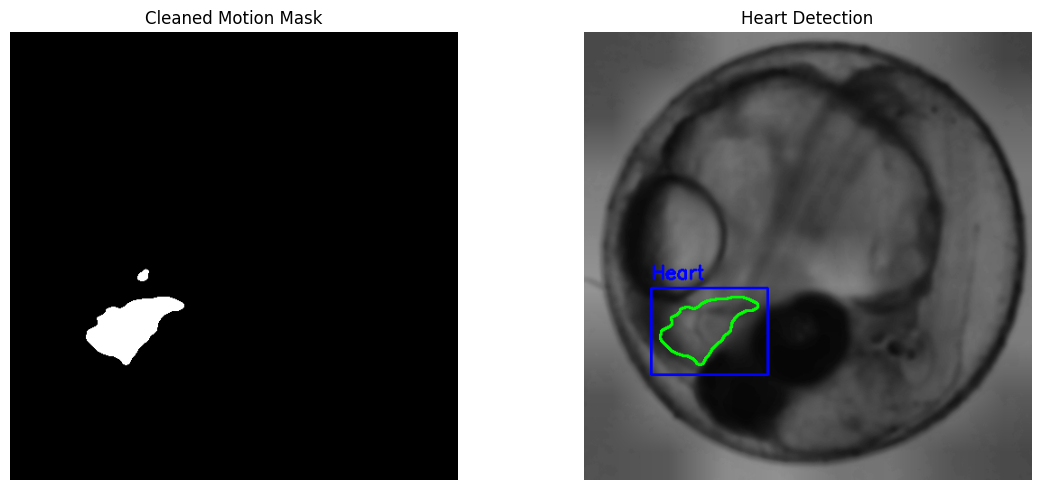

Detected heart region:
  Area: 4120 px²


In [53]:
# Detect heart region from motion threshold
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (7, 7))
motion_clean = cv.morphologyEx(motion_threshold, cv.MORPH_CLOSE, kernel, iterations=2)
motion_clean = cv.morphologyEx(motion_clean, cv.MORPH_OPEN, kernel)

# Find contours
contours, _ = cv.findContours(motion_clean, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Find the largest moving region
heart_contour = max(contours, key=cv.contourArea)

# Get bounding box with some padding
x, y, w, h = cv.boundingRect(heart_contour)
padding = 10
x = max(0, x - padding)
y = max(0, y - padding)
w = min(normalized_images[0].shape[1] - x, w + 2*padding)
h = min(normalized_images[0].shape[0] - y, h + 2*padding)

# Draw results
result_img = cv.cvtColor(normalized_images[0], cv.COLOR_GRAY2BGR)
cv.drawContours(result_img, [heart_contour], -1, (0, 255, 0), 2)
cv.rectangle(result_img, (x, y), (x+w, y+h), (255, 0, 0), 2)
cv.putText(result_img, 'Heart', (x, y-10), cv.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(motion_clean, cmap='gray')
axes[0].set_title('Cleaned Motion Mask')
axes[0].axis('off')

axes[1].imshow(cv.cvtColor(result_img, cv.COLOR_BGR2RGB))
axes[1].set_title('Heart Detection')
axes[1].axis('off')

plt.tight_layout()
plt.show()

area = cv.contourArea(heart_contour)
print(f"Detected heart region:")
print(f"  Area: {area:.0f} px²")

# Bonus: Heart Rate

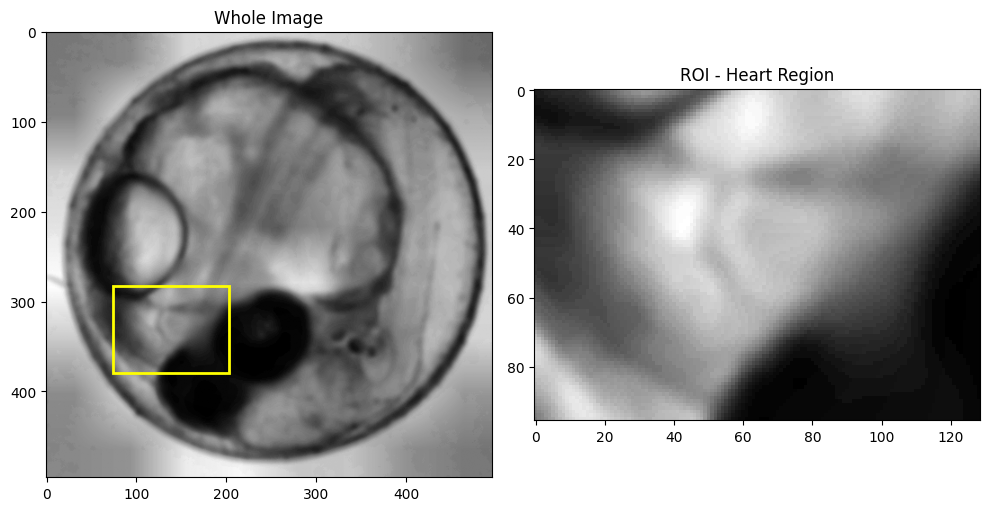

In [54]:
# Extract heart region from all frames
heart_regions = []
for img in normalized_images:
    heart_crop = img[y:y+h, x:x+w]
    heart_regions.append(heart_crop)

heart_regions = np.array(heart_regions)

# print both for verification
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(normalized_images[0], cmap='gray')
# Draw rectangle around heart region
rect = plt.Rectangle((x, y), w, h, edgecolor='yellow', facecolor='none', linewidth=2)
axes[0].add_patch(rect)
axes[0].set_title('Whole Image')

axes[1].imshow(heart_regions[0], cmap='gray')   
axes[1].set_title('ROI - Heart Region')
plt.tight_layout()
plt.show()

In [55]:
# Calculate mean intensity over time for the heart region
heart_signal = np.mean(heart_regions, axis=(1, 2))

# Normalize the signal (z-score normalization)
heart_signal_normalized = (heart_signal - np.mean(heart_signal)) / np.std(heart_signal)

# Calculate rate of change
heart_signal_diff = np.diff(heart_signal_normalized)

In [56]:
# Convert timestamps to integers
timestamps_int = [int(t) for t in timestamps]
time_start = timestamps_int[0]
time_end = timestamps_int[-1]

# Calculate expected frame rate (average time difference)
time_diffs = np.diff(timestamps_int)
avg_time_diff = np.mean(time_diffs)
sd_time_diff = np.std(time_diffs)
print(f"Average time between frames: {avg_time_diff:.1f} units")
print(f"Time range: {time_start} to {time_end}")
print(f"Standard deviation of time differences: {sd_time_diff:.1f} units")

Average time between frames: 77.6 units
Time range: 15372985 to 15382995
Standard deviation of time differences: 13.7 units


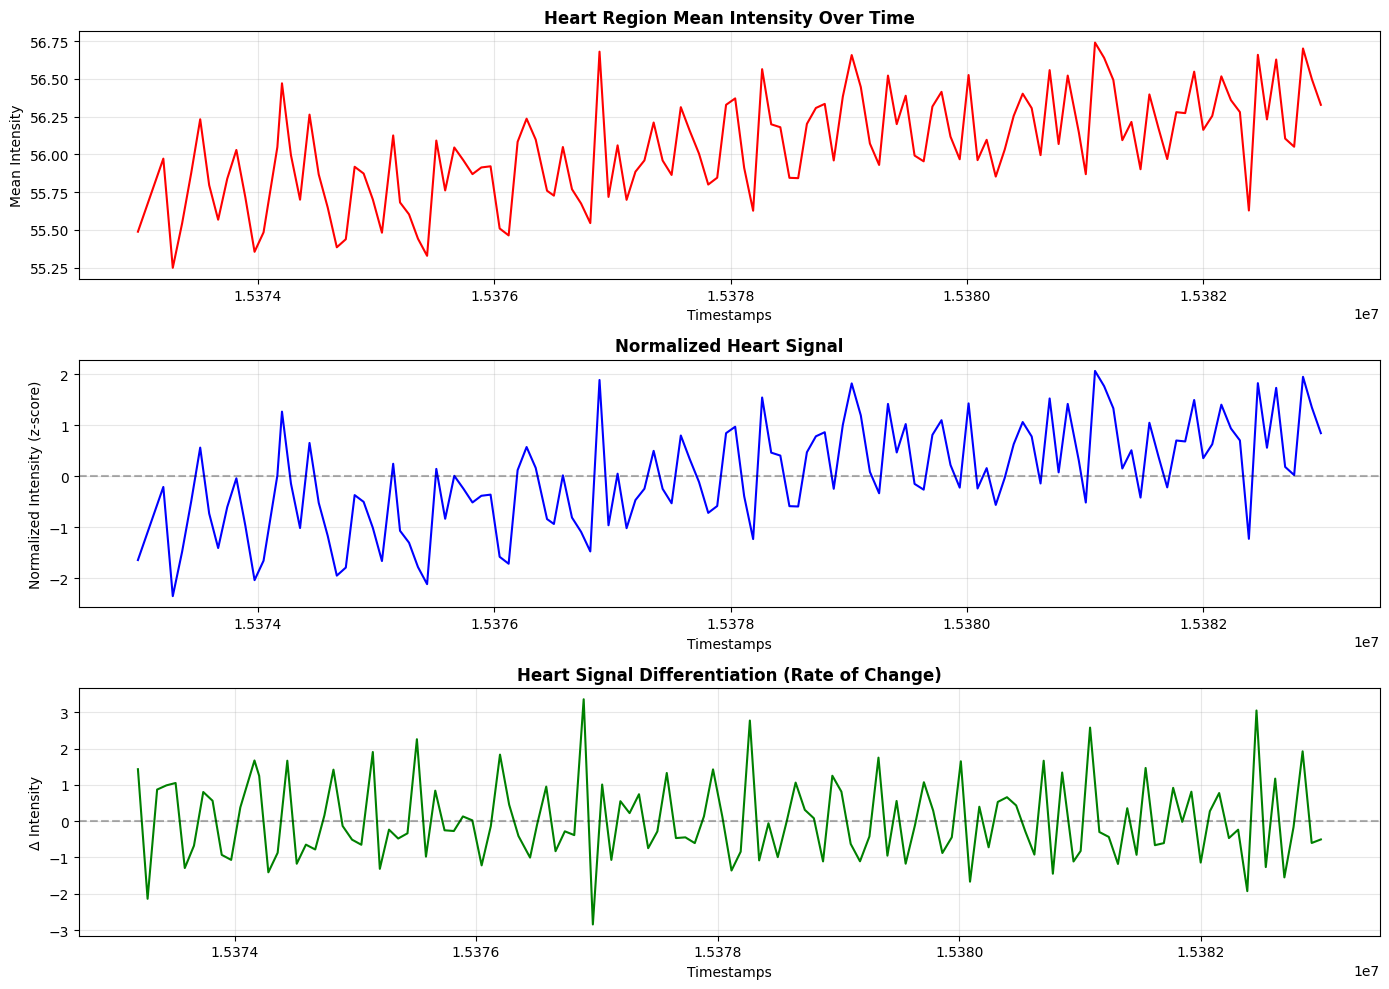

In [57]:
# Visualize the temporal signal
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Original signal
axes[0].plot(timestamps_int, heart_signal, color='red', linewidth=1.5)
axes[0].set_title('Heart Region Mean Intensity Over Time', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Timestamps')
axes[0].set_ylabel('Mean Intensity')
axes[0].grid(True, alpha=0.3)

# Normalized signal
axes[1].plot(timestamps_int, heart_signal_normalized, color='blue', linewidth=1.5)
axes[1].set_title('Normalized Heart Signal', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Timestamps')
axes[1].set_ylabel('Normalized Intensity (z-score)')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='k', linestyle='--', alpha=0.3)

# First derivative (rate of change)
axes[2].plot(timestamps_int[1:], heart_signal_diff, color='green', linewidth=1.5)
axes[2].set_title('Heart Signal Differentiation (Rate of Change)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Timestamps')
axes[2].set_ylabel('Δ Intensity')
axes[2].grid(True, alpha=0.3)
axes[2].axhline(y=0, color='k', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

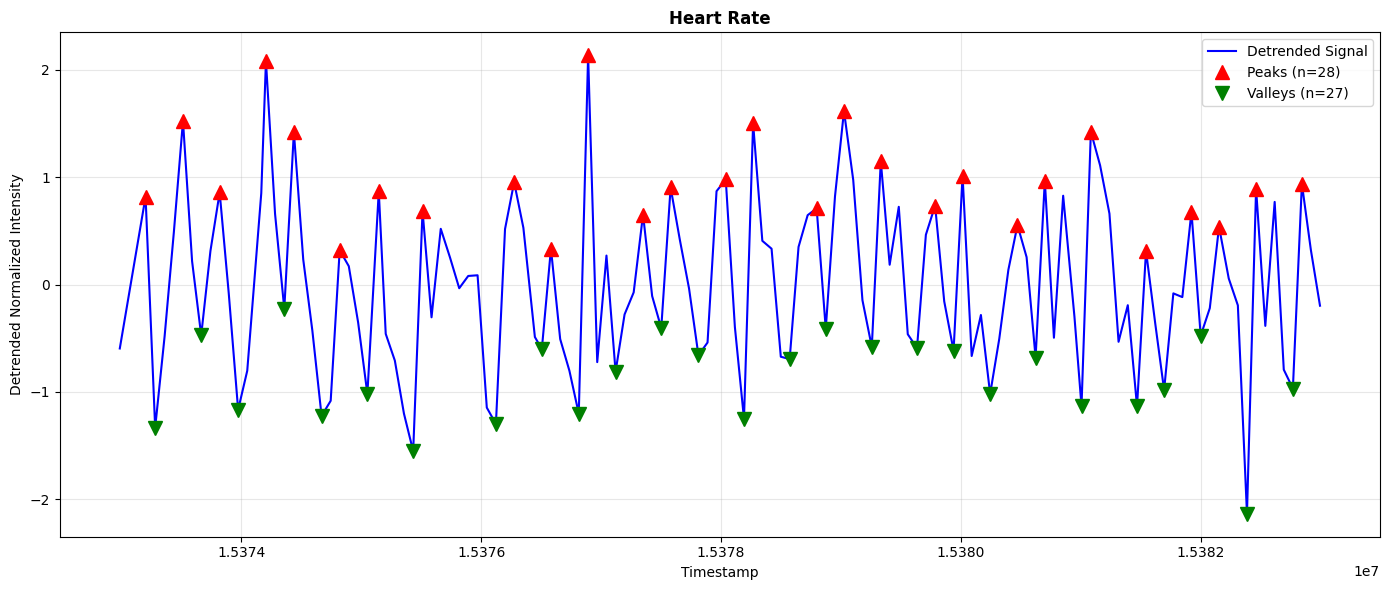

In [58]:
from scipy.signal import find_peaks, detrend

# Detrend the signal to remove slow variations
heart_signal_detrended = detrend(heart_signal_normalized)

# Find peaks
min_distance_frames = 3

peaks, peak_properties = find_peaks(heart_signal_detrended, 
                                     distance=min_distance_frames,
                                     prominence=0.3)  # Minimum prominence

# Find valleys (diastole - relaxation)
valleys, valley_properties = find_peaks(-heart_signal_detrended,
                                         distance=min_distance_frames,
                                         prominence=0.3)

# Visualize peak detection
timestamps_array = np.array(timestamps_int)
plt.figure(figsize=(14, 6))
plt.plot(timestamps_array, heart_signal_detrended, color='blue', linewidth=1.5, label='Detrended Signal')
plt.plot(timestamps_array[peaks], heart_signal_detrended[peaks], 
         'r^', markersize=10, label=f'Peaks (n={len(peaks)})')
plt.plot(timestamps_array[valleys], heart_signal_detrended[valleys], 
         'gv', markersize=10, label=f'Valleys (n={len(valleys)})')
plt.title('Heart Rate', fontsize=12, fontweight='bold')
plt.xlabel('Timestamp')
plt.ylabel('Detrended Normalized Intensity')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Limitations and Future Improvements
- The current approach assumes the heart is the region with the most motion, which may not hold if other structures move significantly
- Machine learning methods could be explored for more robust heart region segmentation.
- The approach may not scale well to different embryos or orientations, since if the embryo appears in another position or rotated, the detected heart region might not move as clearly or be properly localized.
- Although small timing differences between frames were minor, a time interpolation step could be added to produce a clearer and more accurate heartbeat signal. This was not applied here, as the focus was on demonstrating the approach rather than maximizing precision or performance.
